<h1 align="center" style="background-color:DodgerBlue;">Prueba II - Machine Learning </h1>

### Contexto
En esta ocasión trabajaremos con datos públicos del departamento de policía de New York. El dataset es llamado stop_and_frisk_data y contiene información sobre interrogaciones y detenciones realizadas por el departamento de policía de NY en la vía pública. El diccionario de atributos se encuentra en el archivo 2009 SQF File Spec.xls.
Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer notar que los datos que estamos utilizando son un muestreo del de la cantidad de registros reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de entrenamiento y procesamiento que requiere el volumen de datos reales.

Descripción del problema y objetivos
Utilizando el dataset stop_and_frisk_data.csv , el que corresponde a datos públicos del departamento policial de Nueva York, se abordarán dos problemas de clasificación binaria.

Primero, se requiere predecir si un determinado precedimiento policial concluirá en un arresto o no, para ello se generará un modelos predictivos, el que será depurado según los resultados de las métricas resultantes. La variable objetivo es 'arstmade'.

Segundo, se requiere predecir si el procedimiento policial concluirá en una acción violenta, para ellos se generará un nueva variable objetivo llamada 'force_police' que incluye atributos que indican violencia, como 'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_baton', entre otros. 

Para ambos problemas, se utilizarán los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de test.

Aspectos Computacionales

In [143]:
# Importacuiones clasicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Informacion del sistema y datos perdidos
from sinfo import sinfo
import missingno as msngo

# Buscador de modelos
from lazypredict.Supervised import LazyClassifier, LazyRegressor

# MAchine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

from collections import Counter
# Importaaciones especializadas
import preproc_nyc_sqf as func

import pickle

# Otras importaciones y intancias para este desafio
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

Fuciones auxiliares y su objetivo

Se usará la función preproc_nyc_sqf para normalizar la cantidad de atributos del dataframe.

Se entrenaran los modelos con una grilla de hiperparámetros tentativa (5)
1.Para LogisticRegression:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

2.Para Random Forest:
params = {'max_features':[None, 'log2', 'sqrt'], 'n_estimators': [50,100,150,200,250,500], 'max_depth':[None, 2, 5, 7, 10]}

3.Para AdaBoostClassifier:
params = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000, 2000]}

4.Para GradientBoostingClassifier:
params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000],'subsample': [0.1, 0.5, 0.9]}

5.Para SVC:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [2]:
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
imblearn            0.9.1
lazypredict         0.2.12
matplotlib          3.5.3
missingno           0.5.1
numpy               1.21.5
pandas              1.4.4
preproc_nyc_sqf     NA
seaborn             0.12.1
sinfo               0.3.4
sklearn             1.1.3
-----
IPython             7.31.1
jupyter_client      7.4.7
jupyter_core        4.11.2
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.9.12 (main, Apr  5 2022, 01:53:17) [Clang 12.0.0 ]
macOS-10.16-x86_64-i386-64bit
8 logical CPU c

In [3]:
help(func.create_suitable_dataframe)
help(func.dist_box)

Help on function create_suitable_dataframe in module preproc_nyc_sqf:

create_suitable_dataframe(df)
    TODO: Crea un dataframe apto para entrenamiento de acuerdo a normas básicas de limpieza de datos faltantes,
        transformación de etiquetas nulas en variables categóricas y crea atributos sinteticos de edad del sospechoso
         y conversión de distancia a sistema metrico.
    Argumentos:
        - df: Un objeto pandas.DataFrame 
    returns:

Help on function dist_box in module preproc_nyc_sqf:

dist_box(data)
    Funcion que imprime grafico de las distribuciones de un 
    dataframe completo.
    Args:
        data (DataFrame): Conjunto de datos
    Returns:
        distplots: con todas las variables del df



In [4]:
# carga set dfe datos
df_2009 = pd.read_csv('2009_1perc.csv').drop(columns = ['Unnamed: 0', 'year'])
df_2010 = pd.read_csv('2010_1perc.csv').drop(columns = ['Unnamed: 0', 'year'])

In [5]:
df_2009.shape

(5812, 110)

<AxesSubplot:>

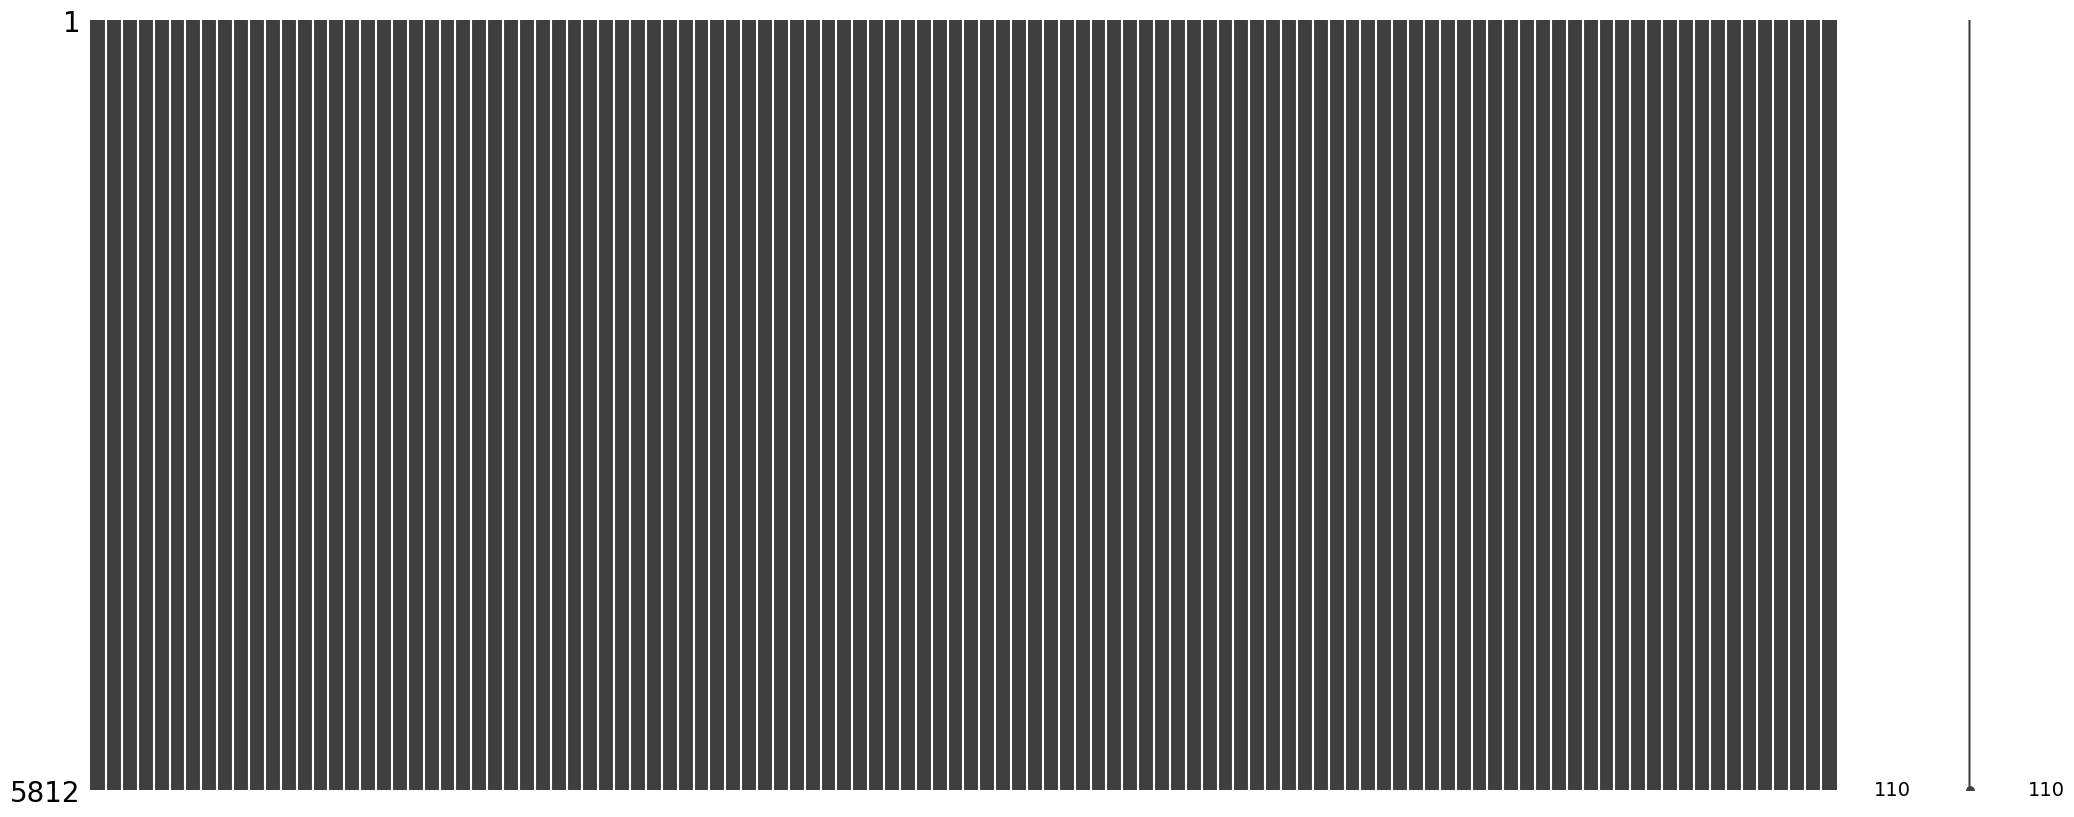

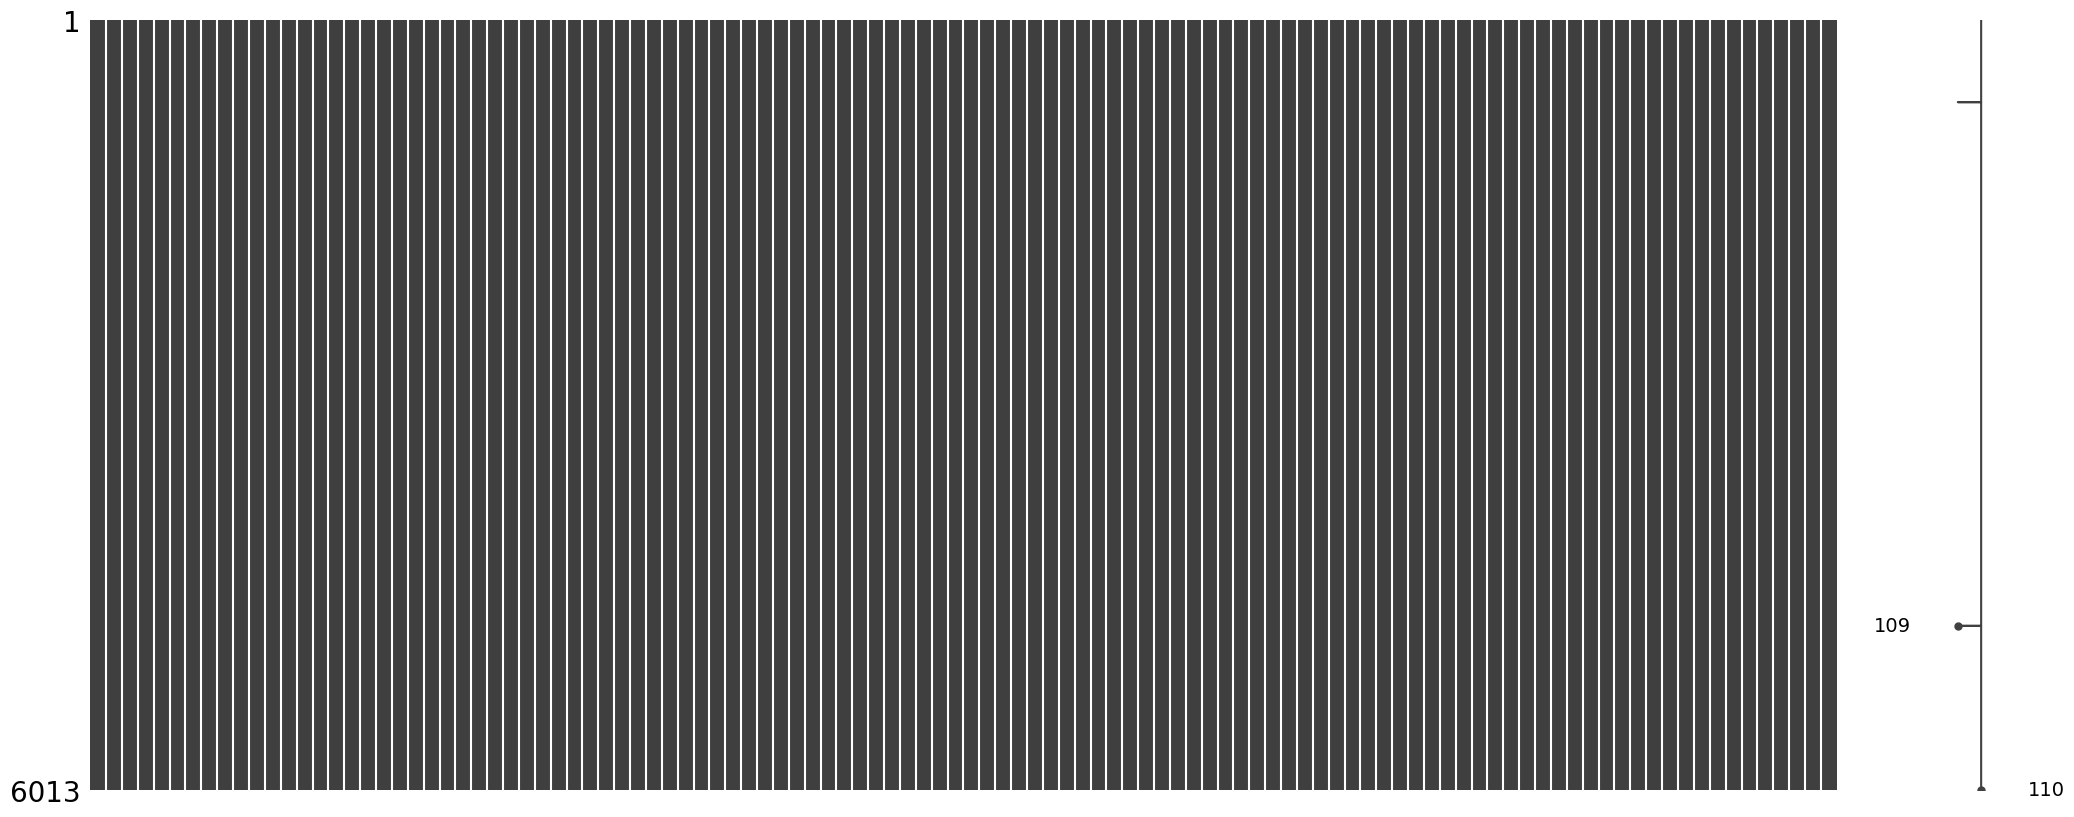

In [6]:
msngo.matrix(df_2009)
msngo.matrix(df_2010)

In [7]:
# Instanciacion de funciones especiales para este desafio
df_train, suitable_categorical_attributesf_2009, suitable_numerical_attributesf_2009 = func.create_suitable_dataframe(df_2009)
df_test, suitable_categorical_attributes_2010, suitable_numerical_attributes_2010 = func.create_suitable_dataframe(df_2010)

['pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'addrpct', 'linecm', 'detailcm', 'perobs']
['pct', 'ser_num', 'datestop', 'timestop', 'perobs', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight']


In [8]:
# Revision de DataFrame proc_df
df_train

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,race,haircolr,eyecolor,build,city,sector,beat,post,month,meters
0,A,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,M,BRONX,G,7,,4,1.80
2,1,O,P,V,Y,N,N,N,N,N,...,Q,BR,BR,M,BRONX,E,U,,10,1.92
3,A,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,T,BROOKLYN,J,4,35,12,1.68
5,1,I,T,V,Y,N,N,N,N,Y,...,B,BK,BR,M,MANHATTAN,F,16,,5,1.77
6,1,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,T,BROOKLYN,N,U,,11,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,A,O,P,V,Y,Y,N,N,Y,N,...,B,BK,BR,M,BRONX,N,U,3,5,1.55
5808,A,O,P,P,Y,N,N,N,N,N,...,B,BK,BR,T,BROOKLYN,F,17,,9,1.56
5809,1,O,P,P,Y,N,N,N,Y,N,...,B,BK,BR,M,BROOKLYN,B,U,,6,1.74
5810,1,O,H,P,Y,N,Y,N,Y,N,...,B,BK,BR,T,BROOKLYN,A,10,,3,1.77


## Graficos de variables que identifican al individuo

Se realizara un analisis exploratorio de las caracteristicas de los individuos registrados en el dataset, bajo las siguientes observaciones:`'sex','race','haircolr','eyecolor','build'`

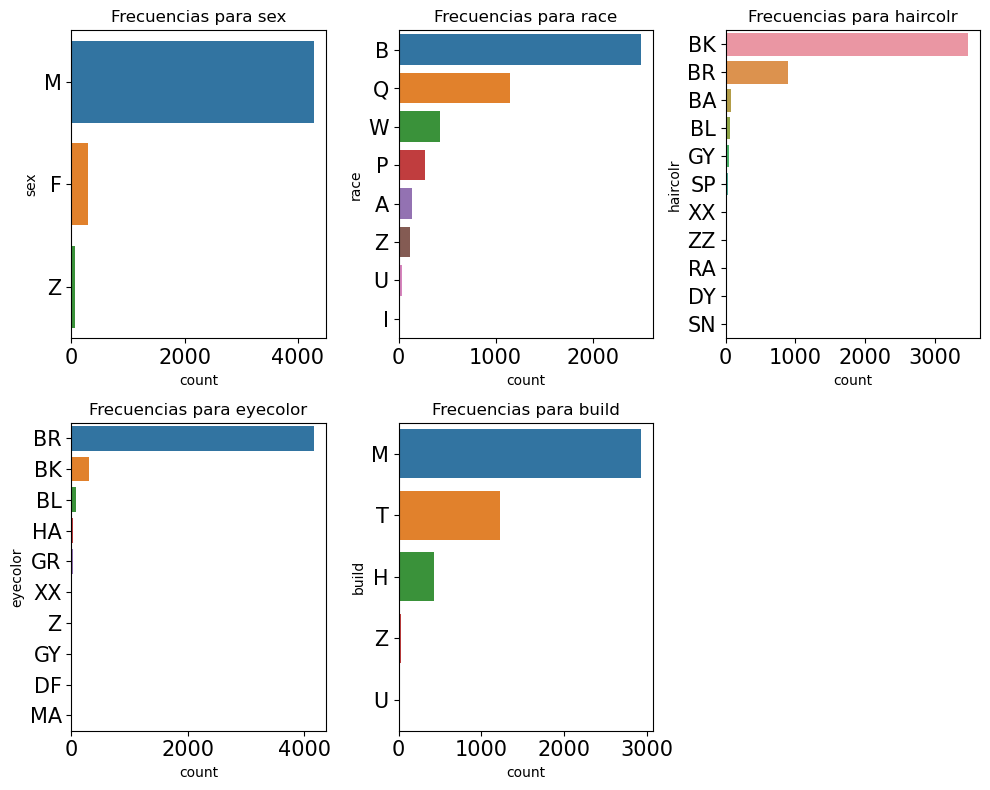

In [59]:
variables_individuo = ['sex','race','haircolr','eyecolor','build']
df_train_individuo = df_train.loc[:,variables_individuo]

for n, i in enumerate(variables_individuo):
    plt.subplot(2, 3, n + 1)
    sns.countplot(y= df_train_individuo[i], order=df_train_individuo[i].value_counts().index)
    plt.title('Frecuencias para {}'.format(i))
    plt.tight_layout()

<AxesSubplot:>

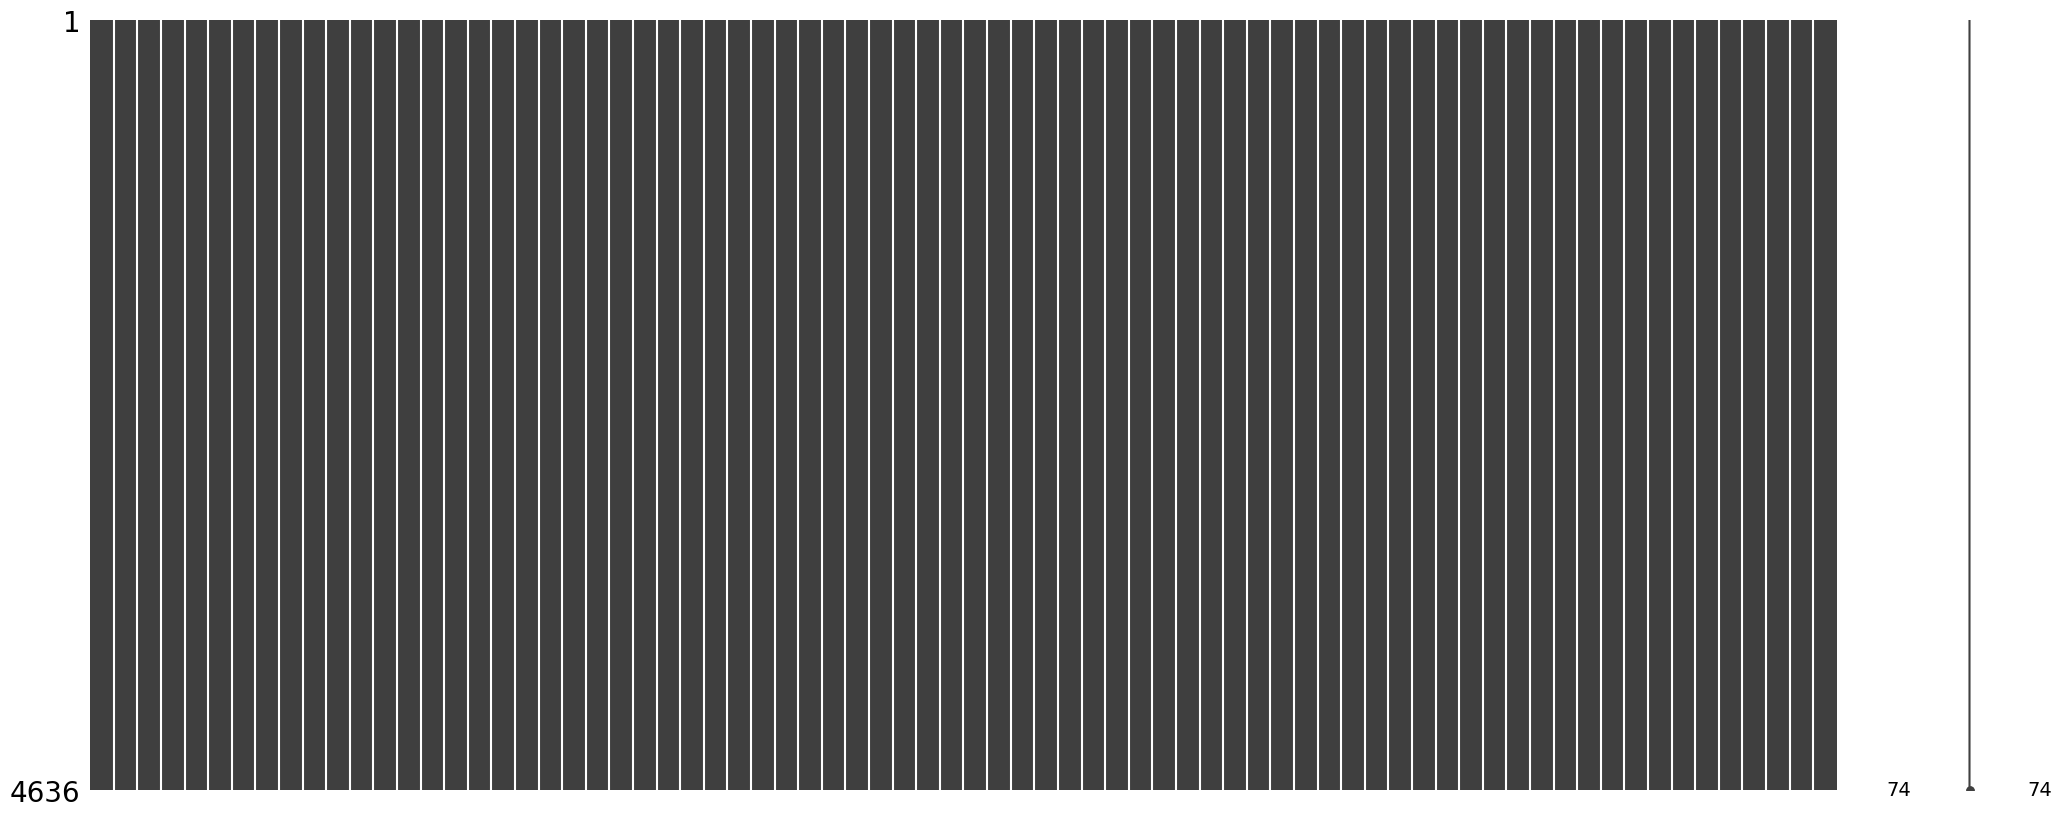

In [15]:
msngo.matrix(df_train)

El dataset no presenta datos perdidos.

In [16]:
# Revision de variable arstmade
df_train['arstmade'].value_counts()

N    4355
Y     281
Name: arstmade, dtype: int64

<AxesSubplot:title={'center':'Cantidad de procedimientos que concluyen en arresto (Y) o no (N)'}, xlabel='arstmade', ylabel='count'>

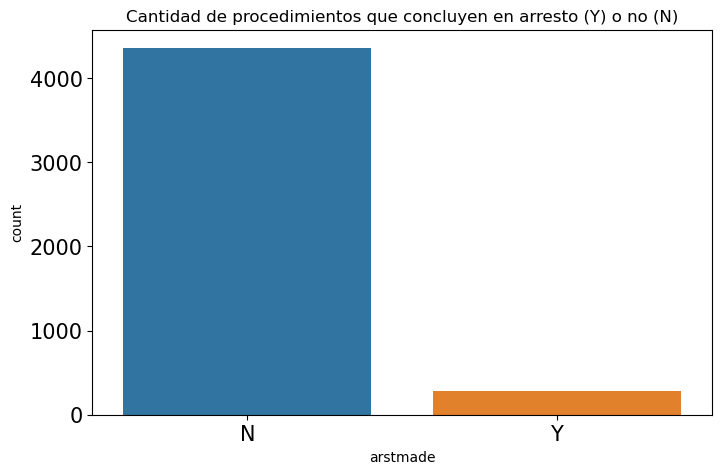

In [60]:
#VARIABLE ARSTMADE
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.title('Cantidad de procedimientos que concluyen en arresto (Y) o no (N)')
sns.countplot(x = 'arstmade', data = df_train)


In [18]:
# Nuevo dataframe para graficos
df_catplot = df_train[['arstmade', 'city', 'race', 'sex']]
df_catplot

,arstmade,city,race,sex
0,N,BRONX,B,M
2,N,BRONX,Q,M
3,N,BROOKLYN,B,M
5,N,MANHATTAN,B,M
6,N,BROOKLYN,B,M
...,...,...,...,...
5806,N,BRONX,B,M
5808,N,BROOKLYN,B,M
5809,N,BROOKLYN,B,M
5810,Y,BROOKLYN,B,M


In [19]:
# Preprocesamiento de variables parta graficos
df_catplot['city_l'] = LabelEncoder().fit_transform(df_catplot['city'])
df_catplot['race_l'] = LabelEncoder().fit_transform(df_catplot['race'])
df_catplot['sex_l'] = LabelEncoder().fit_transform(df_catplot['sex'])
df_catplot['arstmade_l'] = LabelEncoder().fit_transform(df_catplot['arstmade'])
df_catplot.sample(5, random_state = 15820)

,arstmade,city,race,sex,city_l,race_l,sex_l,arstmade_l
3127,N,BROOKLYN,B,M,1,1,1,0
3413,N,BROOKLYN,B,M,1,1,1,0
828,N,MANHATTAN,B,M,2,1,1,0
4920,N,BROOKLYN,B,M,1,1,1,0
2586,N,BROOKLYN,B,M,1,1,1,0


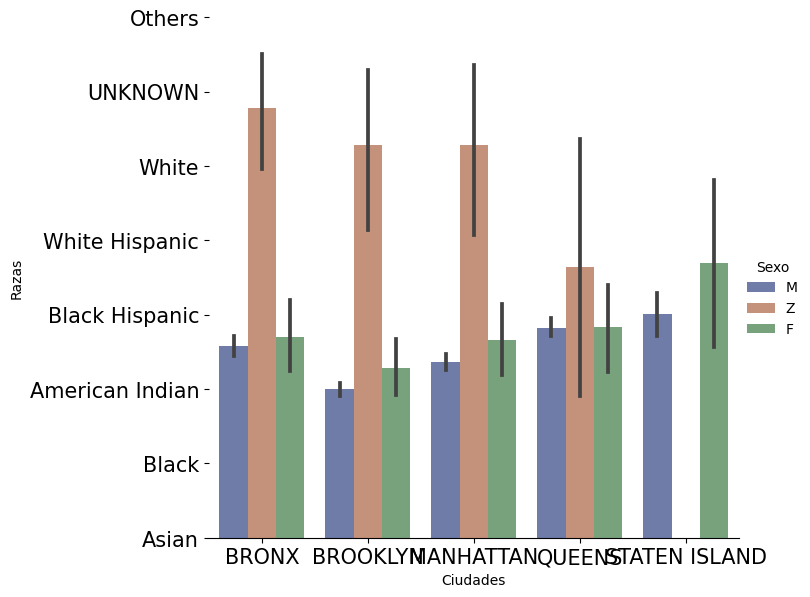

In [20]:
# Distribucion de arrestos por ciudad, sexo y raza
g = sns.catplot(data=df_catplot, kind="bar",
                x = "city_l", y = "race_l", hue = "sex",
                palette = "dark", alpha = .6, height = 6)


g.set_xticklabels(['BRONX','BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'])
g.set_yticklabels(['Asian','Black', 'American Indian', 'Black Hispanic', 'White Hispanic', 'White', 'UNKNOWN', 'Others'])
g.despine(left = True)
g.set_axis_labels("Ciudades", "Razas")
g.legend.set_title("Sexo")

In [21]:
# Renombramos las variables
df_catplot['race'] = df_catplot['race'].replace(['A', 'B', 'I', 'P', 'Q', 'W', 'X', 'Z'], 
            ['ASIAN/PACIFIC ISLANDER', 'BLACK', 'AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK-HISPANIC', 'WHITE-HISPANIC', 'WHITE', 'UNKNOWN', 'OTHER'])

df_catplot['sex'] = df_catplot['sex'].replace(['F', 'M', 'Z'], 
                                        ['FEMALE', 'MALE', 'UNKNOWN'])

In [22]:
# Condicionamos la contatenacion en ciudad, sexo y raza
df_catplot['concat'] = df_catplot.city.str.cat(df_catplot.sex, sep = ' <=> ')
df_catplot['concat'] = df_catplot.concat.str.cat(df_catplot.race, sep = ' <=> ')
df_catplot

,arstmade,city,race,sex,city_l,race_l,sex_l,arstmade_l,concat
0,N,BRONX,BLACK,MALE,0,1,1,0,BRONX <=> MALE <=> BLACK
2,N,BRONX,WHITE-HISPANIC,MALE,0,4,1,0,BRONX <=> MALE <=> WHITE-HISPANIC
3,N,BROOKLYN,BLACK,MALE,1,1,1,0,BROOKLYN <=> MALE <=> BLACK
5,N,MANHATTAN,BLACK,MALE,2,1,1,0,MANHATTAN <=> MALE <=> BLACK
6,N,BROOKLYN,BLACK,MALE,1,1,1,0,BROOKLYN <=> MALE <=> BLACK
...,...,...,...,...,...,...,...,...,...
5806,N,BRONX,BLACK,MALE,0,1,1,0,BRONX <=> MALE <=> BLACK
5808,N,BROOKLYN,BLACK,MALE,1,1,1,0,BROOKLYN <=> MALE <=> BLACK
5809,N,BROOKLYN,BLACK,MALE,1,1,1,0,BROOKLYN <=> MALE <=> BLACK
5810,Y,BROOKLYN,BLACK,MALE,1,1,1,1,BROOKLYN <=> MALE <=> BLACK


In [23]:
df2 = np.divide(df_catplot.groupby(['concat']).agg({'arstmade_l':sum}), len(df_catplot))
df2

,arstmade_l
concat,
BRONX <=> FEMALE <=> ASIAN/PACIFIC ISLANDER,0.00
BRONX <=> FEMALE <=> BLACK,0.00
BRONX <=> FEMALE <=> BLACK-HISPANIC,0.00
BRONX <=> FEMALE <=> OTHER,0.00
BRONX <=> FEMALE <=> WHITE,0.00
...,...
STATEN ISLAND <=> MALE <=> BLACK-HISPANIC,0.00
STATEN ISLAND <=> MALE <=> OTHER,0.00
STATEN ISLAND <=> MALE <=> U,0.00


In [24]:
# Top 10 de la probabilidad de arresto por city, sex y race
df2 = (df2.sort_values(by = ['arstmade_l'], ascending = False)) * 100
df2.head(10)

,arstmade_l
concat,
MANHATTAN <=> MALE <=> BLACK,1.01
BROOKLYN <=> MALE <=> BLACK,0.84
QUEENS <=> MALE <=> BLACK,0.56
QUEENS <=> MALE <=> WHITE-HISPANIC,0.43
MANHATTAN <=> MALE <=> WHITE-HISPANIC,0.43
BRONX <=> MALE <=> BLACK,0.37
QUEENS <=> MALE <=> WHITE,0.26
BRONX <=> MALE <=> WHITE-HISPANIC,0.26
BROOKLYN <=> MALE <=> WHITE-HISPANIC,0.24


In [25]:
prob_ot = (len(df_catplot[df_catplot['arstmade'] == 'Y']))/len(df_catplot)

In [26]:
# Probabilidad de arresto en alguna ciudad
df_catplot['concat'].value_counts('%').sort_values(ascending = False).head(10)

BROOKLYN <=> MALE <=> BLACK             0.22
MANHATTAN <=> MALE <=> BLACK            0.11
QUEENS <=> MALE <=> BLACK               0.08
QUEENS <=> MALE <=> WHITE-HISPANIC      0.08
BRONX <=> MALE <=> BLACK                0.07
MANHATTAN <=> MALE <=> WHITE-HISPANIC   0.05
BROOKLYN <=> MALE <=> WHITE-HISPANIC    0.05
BRONX <=> MALE <=> WHITE-HISPANIC       0.04
QUEENS <=> MALE <=> WHITE               0.03
BROOKLYN <=> MALE <=> WHITE             0.02
Name: concat, dtype: float64

In [27]:
print('Columnas de x_train y no esta en x_test:')
for col in df_train.columns:
    if col not in list(df_test.columns):
        print(col)




Columnas de x_train y no esta en x_test:
asltweap
post


In [28]:
print('Columnas de x_test y no esta en x_train:')
for col in df_test.columns:
    if col not in list(df_train.columns):
        print(col)

Columnas de x_test y no esta en x_train:
addrtyp
addrpct
dettypcm
linecm
detailcm


In [29]:
df_train = df_train.drop(columns = ['asltweap', 'post'])
df_test = df_test.drop(columns = ['addrtyp', 'addrpct', 'dettypcm', 'linecm', 'detailcm'])

In [30]:
train_df_2009 = pd.DataFrame()
for colums in df_train.columns:
    train_df_2009[colums] = LabelEncoder().fit_transform(df_train[colums])

In [31]:
test_df_2010 = pd.DataFrame()
for colums in df_test.columns:
    test_df_2010[colums] = LabelEncoder().fit_transform(df_test[colums])

Se recodifica el dataset completo incluyendo al vector objetivo artsmade.

In [32]:
train_df_2009

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,sex,race,haircolr,eyecolor,build,city,sector,beat,month,meters
0,1,1,1,1,1,0,0,0,1,0,...,1,1,1,2,1,0,6,27,3,14
1,0,1,1,3,1,0,0,0,0,0,...,1,4,3,2,1,0,4,30,9,19
2,1,1,1,1,1,0,0,0,1,0,...,1,1,1,2,2,1,9,20,11,10
3,0,0,2,3,1,0,0,0,0,1,...,1,1,1,2,1,2,5,7,4,13
4,0,1,1,1,1,0,0,0,1,0,...,1,1,1,2,2,1,12,30,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,1,1,1,3,1,1,0,0,1,0,...,1,1,1,2,1,0,12,30,4,5
4632,1,1,1,1,1,0,0,0,0,0,...,1,1,1,2,2,1,5,8,8,6
4633,0,1,1,1,1,0,0,0,1,0,...,1,1,1,2,1,1,1,30,5,12
4634,0,1,0,1,1,0,1,0,1,0,...,1,1,1,2,2,1,0,1,2,13


In [33]:
test_df_2010

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,sex,race,haircolr,eyecolor,build,city,sector,beat,month,meters
0,0,1,1,1,1,0,0,0,0,1,...,1,6,3,4,2,2,6,61,10,18
1,0,0,2,3,1,0,0,0,1,0,...,1,1,1,2,1,0,4,61,8,19
2,0,0,2,3,1,0,0,0,1,0,...,1,1,1,2,1,2,1,55,5,19
3,0,1,1,3,1,0,0,0,1,0,...,1,4,1,2,1,3,9,61,10,19
4,0,0,2,1,1,0,0,0,1,0,...,1,4,9,2,2,2,2,58,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742,0,1,1,1,1,1,0,0,0,0,...,0,4,3,2,2,3,0,61,5,14
4743,0,1,0,1,1,0,0,0,1,0,...,1,1,1,2,2,1,8,61,8,8
4744,1,1,1,2,1,0,0,0,0,0,...,1,7,1,2,1,1,0,61,6,15
4745,0,1,1,1,1,0,0,0,0,1,...,1,4,1,2,1,3,4,61,10,9


In [34]:
# Creamos la matris de atributos y la separamos del vector objetivo
# Separamos los datos de entrenamiento
X_train = train_df_2009.drop(columns = 'arstmade')
y_train = train_df_2009['arstmade']
X_test = test_df_2010.drop(columns = 'arstmade')
y_test = test_df_2010['arstmade']

In [35]:
print(f'''
{X_train.shape}
{y_train.shape}
{X_test.shape}
{y_test.shape}''')


(4636, 71)
(4636,)
(4747, 71)
(4747,)


In [36]:
smote = SMOTE(random_state = 152, sampling_strategy = 'minority')
x_train_oversam, y_train_oversam = smote.fit_resample(X_train, y_train)

In [37]:
print(f'''
{x_train_oversam.shape}
{y_train_oversam.shape}''')


(8710, 71)
(8710,)


In [38]:
print(f'''Revisión de muestra de entrenamiento sin oversampling
Datos de validacion {sorted(Counter(y_train).items())}

Revisión de muestra de entrenamiento con oversampling
{sorted(Counter(y_train_oversam).items())}''')

Revisión de muestra de entrenamiento sin oversampling
Datos de validacion [(0, 4355), (1, 281)]

Revisión de muestra de entrenamiento con oversampling
[(0, 4355), (1, 4355)]


## Entrenamiento de Grilla de 3 modelos para seleccionar el mejor

In [75]:
%%time
# Calculo de grilla para RandomForest
params_rf = {'max_features': [None , 'log2' , 'sqrt'],'n_estimators': [10,50,100,150,200,250], 'max_depth':[None, 2,5,7,10]}
rf_model_gridcv = GridSearchCV(RandomForestClassifier(random_state = 1), params_rf, cv=5, n_jobs=-1).fit(x_train_oversam,y_train_oversam)
rf_model_gridcv.best_params_


CPU times: user 3.07 s, sys: 303 ms, total: 3.37 s
Wall time: 2min 2s


{'max_depth': None, 'max_features': 'log2', 'n_estimators': 250}

In [76]:
predictions_rf = rf_model_gridcv.predict(X_test)
print(classification_report(y_test,predictions_rf))
print('accuracy: ', round(accuracy_score(y_test,predictions_rf),3))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4438
           1       0.79      0.51      0.62       309

    accuracy                           0.96      4747
   macro avg       0.88      0.75      0.80      4747
weighted avg       0.96      0.96      0.96      4747

accuracy:  0.959


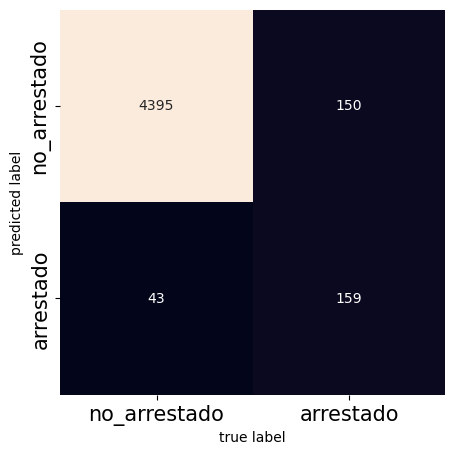

In [97]:
leyenda=['no_arrestado','arrestado']
mat = confusion_matrix(y_test, predictions_rf)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=leyenda, 
    yticklabels=leyenda
)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [141]:
%%time
# Calculo de grilla para LogisticRegresion
params_lg = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2'], 'max_iter':[500]}
lg_model_gridcv = GridSearchCV(LogisticRegression(random_state = 1, solver='saga'), params_lg, cv=5, n_jobs=-1).fit(x_train_oversam,y_train_oversam)
lg_model_gridcv.best_params_

/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-pack

CPU times: user 5.47 s, sys: 269 ms, total: 5.74 s
Wall time: 1min 16s


{'C': 10, 'max_iter': 500, 'penalty': 'l1'}

Lamentamos no poder dejar este warning oculto, probamos varios metodos sin exito (puede revisar la implemantación de librerias)

In [83]:
predictions_lg = lg_model_gridcv.predict(X_test)
print(classification_report(y_test,predictions_lg))
print('accuracy: ', round(accuracy_score(y_test,predictions_lg),3))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4438
           1       0.49      0.63      0.55       309

    accuracy                           0.93      4747
   macro avg       0.73      0.79      0.76      4747
weighted avg       0.94      0.93      0.94      4747

accuracy:  0.933


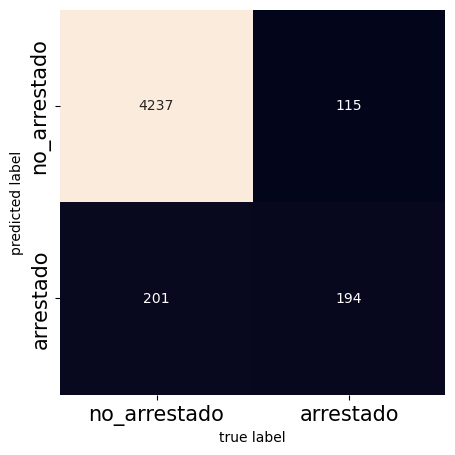

In [98]:
leyenda=['no_arrestado','arrestado']
mat = confusion_matrix(y_test, predictions_lg)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=leyenda, 
    yticklabels=leyenda
)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [88]:
%%time
# Calculo de grilla para LogisticRegresion
params_ada = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000, 2000]}
adb_model_gridcv = GridSearchCV(AdaBoostClassifier(random_state = 1), params_ada, cv=5, n_jobs=-1).fit(x_train_oversam,y_train_oversam)
adb_model_gridcv.best_params_

CPU times: user 8.52 s, sys: 147 ms, total: 8.67 s
Wall time: 1min 59s


{'learning_rate': 0.5, 'n_estimators': 1000}

In [89]:
predictions_ada = adb_model_gridcv.predict(X_test)
print(classification_report(y_test,predictions_ada))
print('accuracy: ', round(accuracy_score(y_test,predictions_ada),3))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4438
           1       0.41      0.65      0.51       309

    accuracy                           0.92      4747
   macro avg       0.69      0.79      0.73      4747
weighted avg       0.94      0.92      0.93      4747

accuracy:  0.918


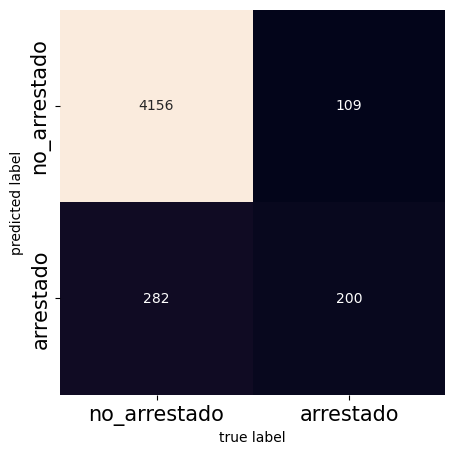

In [99]:
leyenda=['no_arrestado','arrestado']
mat = confusion_matrix(y_test, predictions_ada)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=leyenda, 
    yticklabels=leyenda
)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### El modelo con mejores metricas a la hora de predecir un arresto es RandomForestClassifier
Los siguientes hiperparametros, son los que obtinen las mejoras metricas({'max_depth': None, 'max_features': 'log2', 'n_estimators': 250})

In [96]:
print(classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4438
           1       0.79      0.51      0.62       309

    accuracy                           0.96      4747
   macro avg       0.88      0.75      0.80      4747
weighted avg       0.96      0.96      0.96      4747



Se seleccionarán los 30 atributos más relevantes y se reentrenará el modelo anterior

In [100]:
df_importances = pd.DataFrame(zip(X_train.columns,rf_model_gridcv.best_estimator_.feature_importances_), columns=['atributo', 'importance']).sort_values(by='importance', ascending=False)
df_importances.head(30)

,atributo,importance
10,searched,0.08
56,sb_other,0.06
41,cs_furtv,0.05
34,cs_casng,0.05
3,typeofid,0.05
7,offunif,0.04
67,sector,0.04
49,ac_time,0.04
70,meters,0.03
69,month,0.03


In [101]:
X_train_import = X_train.loc[:,list(df_importances.head(30)['atributo'])]
X_test_import = X_test.loc[:,list(df_importances.head(30)['atributo'])]

In [102]:
smote_treinta = SMOTE(random_state=1, sampling_strategy = 'minority')
X_train_oversampled_treinta, y_train_oversampled_treinta = smote.fit_resample(X_train_import,y_train)

### RandomForest con los 30 principales atributos

In [104]:
params = {'max_features': [None , 'log2' , 'sqrt'],'n_estimators': [10,50,100,150,200,250], 'max_depth':[None, 2,5,7,10]}

rf_model_gridcv_treinta = GridSearchCV(RandomForestClassifier(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_oversampled_treinta,y_train_oversampled_treinta)


In [106]:
predictions_rf_treinta = rf_model_gridcv_treinta.predict(X_test_import)
print(classification_report(y_test,predictions_rf_treinta))
print('accuracy: ', round(accuracy_score(y_test,predictions_rf_treinta),3))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4438
           1       0.64      0.54      0.59       309

    accuracy                           0.95      4747
   macro avg       0.81      0.76      0.78      4747
weighted avg       0.95      0.95      0.95      4747

accuracy:  0.95


Se puede observar que al determinar los 30 atributos mas importantes, el modelo tiende a bajar un poco su nivel de accuracy de un .96 a .95. Los cinco principales atributos para realizar la predicción, segun `.best_estimator_.feature_importances_` son: `searched, sb_other, cs_furtv, cs_casng, typeofid`.

In [144]:
pickle.dump(rf_model_gridcv, open('rf_model_gridcv_jgh.sav', 'wb'))

### DF modelo 'force_process'
#### Generación de variable objetivo: `'force_police'`
Para elaborar esta variable se considera todos los atributos que comiencen con `pf_xx`

In [165]:
# filtrar todas las variables con pf_xx
force_police = train_df_2009.filter(regex='^pf_',axis = 1)
force_police

,pf_hands,pf_wall,pf_grnd,pf_drwep,pf_ptwep,pf_baton,pf_hcuff,pf_pepsp,pf_other
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4631,1,0,0,0,0,0,0,0,0
4632,1,0,0,0,0,0,0,0,0
4633,0,0,0,0,0,0,0,0,0
4634,0,0,0,0,0,0,1,0,0


In [166]:
# Realizamos una copia del dataset original para trabajar con la nueva variable objetivo.
train_df_forcepolice_2009 = train_df_2009.copy()
test_df_forcepolice_2010 = test_df_2010.copy()


In [167]:
logical_sentence_train = (train_df_forcepolice_2009['pf_wall'] == 1) | (train_df_forcepolice_2009['pf_drwep'] == 1) |\
                (train_df_forcepolice_2009['pf_hands'] == 1) | (train_df_forcepolice_2009['pf_grnd'] == 1) |\
                (train_df_forcepolice_2009['pf_ptwep'] == 1) | (train_df_forcepolice_2009['pf_baton'] == 1)|\
                (train_df_forcepolice_2009['pf_hcuff'] == 1) | (train_df_forcepolice_2009['pf_pepsp'] == 1)|\
                (train_df_forcepolice_2009['pf_other'] == 1)

In [168]:

logical_sentence_test = (test_df_forcepolice_2010['pf_wall'] == 1) | (test_df_forcepolice_2010['pf_drwep'] == 1) |\
                (test_df_forcepolice_2010['pf_hands'] == 1) | (test_df_forcepolice_2010['pf_grnd'] == 1) |\
                (test_df_forcepolice_2010['pf_ptwep'] == 1) | (test_df_forcepolice_2010['pf_baton'] == 1) |\
                (test_df_forcepolice_2010['pf_hcuff'] == 1) | (test_df_forcepolice_2010['pf_pepsp'] == 1) |\
                (test_df_forcepolice_2010['pf_other'] == 1)

In [169]:
train_df_forcepolice_2009['force_police'] = np.where(logical_sentence_train,1,0)
test_df_forcepolice_2010['force_police'] = np.where(logical_sentence_test,1,0)

train_df_forcepolice_2009.drop(force_police.columns, axis = 1, inplace=True)
test_df_forcepolice_2010.drop(force_police.columns, axis = 1, inplace=True)

In [170]:
X_train_forcepolice = train_df_forcepolice_2009.drop('force_police', axis=1)
X_test_forcepolice = test_df_forcepolice_2010.drop('force_police', axis=1)
y_train_forcepolice = train_df_forcepolice_2009['force_police']
y_test_forcepolice = test_df_forcepolice_2010['force_police']

In [173]:
print(f'''
Shape de X_train: {X_train_forcepolice.shape} 
Shape de y_train: {y_train_forcepolice.shape}
Shape de X_test: {X_test_forcepolice.shape} 
Shape de y_test: {y_test_forcepolice.shape}

La frecuencia de clases del vector objetivo es: 
#{y_train_forcepolice.value_counts('%')}''')


Shape de X_train: (4636, 63) 
Shape de y_train: (4636,)
Shape de X_test: (4747, 63) 
Shape de y_test: (4747,)

La frecuencia de clases del vector objetivo es: 
0   0.75
1   0.25
Name: force_police, dtype: float64


#### Entrenamiento de cinco modelos predictivos con hiperparametros: 

1 Logistic Regresion: `params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}`

2 Random Forest: `params = {'max_features':[None, 'log2', 'sqrt'], 'n_estimators': [50,100,150,200,250,500], 'max_depth':[None, 2, 5, 7, 10]}`

3 AdaBoost: `params = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000, 2000]}`

4 GradientBoosting: `params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000],'subsample': [0.1, 0.5, 0.9]}`

5 SVM: `params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}`

In [175]:
%%time
##### Busqueda de mejores parametros bajo GridSearchCV para LogisticRegression

params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

logistic_gridcv_forcepolice = GridSearchCV(LogisticRegression(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_forcepolice,y_train_forcepolice)
print(f'''Los mejores hiperparametros para LogisticRegression son:
{logistic_gridcv_forcepolice.best_params_}''')

/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Los mejores hiperparametros para LogisticRegression son:
{'C': 0.1, 'penalty': 'l2'}
CPU times: user 398 ms, sys: 41.1 ms, total: 439 ms
Wall time: 1.68 s


In [177]:
predictions_lr_forcepolice = logistic_gridcv_forcepolice.predict(X_test_forcepolice)
print(classification_report(y_test_forcepolice,predictions_lr_forcepolice))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3639
           1       0.55      0.10      0.16      1108

    accuracy                           0.77      4747
   macro avg       0.67      0.54      0.52      4747
weighted avg       0.73      0.77      0.70      4747



In [178]:
%%time
##### Busqueda de mejores parametros bajo GridSearchCV para RandomForest

params = {'max_features':[None, 'log2', 'sqrt'], 'n_estimators': [50,100,150,200,250,500], 'max_depth':[None, 2, 5, 7, 10]}

randomforest_gridcv_forcepolice = GridSearchCV(RandomForestClassifier(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_forcepolice,y_train_forcepolice)
print(f'''Los mejores hiperparametros para RandomForestClassifier son:
{randomforest_gridcv_forcepolice.best_params_}''')

Los mejores hiperparametros para RandomForestClassifier son:
{'max_depth': None, 'max_features': 'log2', 'n_estimators': 150}
CPU times: user 2.25 s, sys: 182 ms, total: 2.43 s
Wall time: 2min 40s


In [179]:
predictions_rf_forcepolice = randomforest_gridcv_forcepolice.predict(X_test_forcepolice)
print(classification_report(y_test_forcepolice,predictions_rf_forcepolice))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      3639
           1       0.56      0.17      0.26      1108

    accuracy                           0.77      4747
   macro avg       0.67      0.56      0.56      4747
weighted avg       0.74      0.77      0.73      4747



In [180]:
%%time
##### Busqueda de mejores parametros bajo GridSearchCV para AdaBoostClassifier

params = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000, 2000]}

adaboost_gridcv_forcepolice = GridSearchCV(AdaBoostClassifier(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_forcepolice,y_train_forcepolice)
print(f'''Los mejores hiperparametros para AdaBoostClassifier son:
{adaboost_gridcv_forcepolice.best_params_}''')

Los mejores hiperparametros para AdaBoostClassifier son:
{'learning_rate': 0.01, 'n_estimators': 2000}
CPU times: user 10.9 s, sys: 345 ms, total: 11.2 s
Wall time: 1min 36s


In [181]:
predictions_ab_forcepolice = adaboost_gridcv_forcepolice.predict(X_test_forcepolice)
print(classification_report(y_test_forcepolice,predictions_ab_forcepolice))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      3639
           1       0.54      0.15      0.24      1108

    accuracy                           0.77      4747
   macro avg       0.67      0.56      0.55      4747
weighted avg       0.73      0.77      0.72      4747



In [182]:
%%time
##### Busqueda de mejores parametros bajo GridSearchCV para GradientBoostingClassifier

params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000],'subsample': [0.1, 0.5, 0.9]}

gradient_gridcv_forcepolice = GridSearchCV(GradientBoostingClassifier(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_forcepolice,y_train_forcepolice)
print(f'''Los mejores hiperparametros para GradientBoostingClassifier son:
{gradient_gridcv_forcepolice.best_params_}''')

Los mejores hiperparametros para GradientBoostingClassifier son:
{'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9}
CPU times: user 7.28 s, sys: 223 ms, total: 7.5 s
Wall time: 3min 3s


In [183]:
predictions_gb_forcepolice = gradient_gridcv_forcepolice.predict(X_test_forcepolice)
print(classification_report(y_test_forcepolice,predictions_gb_forcepolice))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      3639
           1       0.52      0.21      0.30      1108

    accuracy                           0.77      4747
   macro avg       0.66      0.57      0.58      4747
weighted avg       0.73      0.77      0.73      4747



In [195]:
%%time
##### Busqueda de mejores parametros bajo GridSearchCV para SVC

params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

svc_gridcv_forcepolice = GridSearchCV(SVC(random_state = 1), params, cv=5, n_jobs=-1).fit(X_train_forcepolice,y_train_forcepolice)
print(f'''Los mejores hiperparametros para SVC son:
{svc_gridcv_forcepolice.best_params_}''')

Los mejores hiperparametros para SVC son:
{'C': 100}
CPU times: user 1.35 s, sys: 37.6 ms, total: 1.39 s
Wall time: 20 s


In [196]:
predictions_svc_forcepolice = svc_gridcv_forcepolice.predict(X_test_forcepolice)
print(classification_report(y_test_forcepolice,predictions_svc_forcepolice))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      3639
           1       0.23      0.36      0.28      1108

    accuracy                           0.57      4747
   macro avg       0.49      0.49      0.48      4747
weighted avg       0.64      0.57      0.59      4747



De los cinco modelos entrenados con busqueda de grilla, el que mejor metricas obtenemoos es `GradientBoostingClassifier`, el cual obtine un `accuracy` del .77. Esta evaluacion es compartida por otros modelos, pero dejamos este, porque el `precision` es el mas alto con un 0.52.

In [199]:
pickle.dump(gradient_gridcv_forcepolice, open('gradient_gridcv_forcepolice_jgh.sav', 'wb'))